In [71]:
!pip3 install pandas folium gmplot scipy matplotlib numpy scipy july calplot

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
%reset
import pandas as pd
import numpy as np
import calplot
from scipy import stats
from datetime import datetime
import july
from july.utils import date_range
from scipy.signal import medfilt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import requests
import concurrent.futures
from typing import TypeVar, Generic, Union, Any, List, Dict



# Main Test Data from 2022-12-10

In [3]:
# Based on the frirst test BT
fileName = "20221210.csv"
fromTimestamp = 1670682991406230449
untilTimestamp = 1670684529378910779
complement = "imu/"
mainoffset=abs(-10.211664644999999)

# fromTimestamp = 1673879675841354608
# untilTimestamp = 1673891225373239278
# fileName = "20230116.csv"
# complement = "acc/"
# mainoffset = -9.332008140000001

axisName = "Az"
timestampName = "timestamp"
imuFileLocation = "../test-data/" + complement + fileName
gnssFileLocation = "../test-data/gnss/" + fileName
gnssdata = pd.read_csv(gnssFileLocation, on_bad_lines='skip')
imudata = pd.read_csv(imuFileLocation, on_bad_lines='skip')

def getOffsetAZ():
    return mainoffset

# Filter rows between the start and end timestamps
imu_data = imudata[(imudata[timestampName] >= fromTimestamp) & (imudata[timestampName] <= untilTimestamp)]
imu_data[axisName] = imu_data[axisName] + getOffsetAZ()
az = imu_data[axisName] 

# Gnss

# FIRSTSAMLE = 700
# Get the number of items before data filtering
items_before = len(gnssdata)

# Remove duplicate rows based on latitude and longitude columns
gnssdata = gnssdata.drop_duplicates(subset=['latitude', 'longitude'])

# Drop the 0,0 points 
gnssdata = gnssdata.drop(gnssdata[gnssdata['latitude'] == 0].index)
gnssdata = gnssdata.drop(gnssdata[gnssdata['longitude'] == 0].index)

# Convert timestamp to datetime
gnssdata['timestamp'] = pd.to_datetime(gnssdata['timestamp'])
imu_data['timestamp'] = pd.to_datetime(imu_data['timestamp'])

# Format timestamp to a human-readable string
# gnssdata['timestamp'] = gnssdata['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
# Get the number of items after data filtering
items_after = len(gnssdata)

# Print the number of items before and after filtering
print("Number of items before filtering:", items_before)
print("Number of items after filtering:", items_after)

Number of items before filtering: 13869
Number of items after filtering: 2772


/var/folders/tp/gxh8qwy15j73y5xzvn4gch1c0000gn/T/ipykernel_86977/1550161459.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imu_data[axisName] = imu_data[axisName] + getOffsetAZ()
/var/folders/tp/gxh8qwy15j73y5xzvn4gch1c0000gn/T/ipykernel_86977/1550161459.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imu_data['timestamp'] = pd.to_datetime(imu_data['timestamp'])


## Main Functions

## Manually Upload

In [74]:
apiKey = "haw-team5-d410f8dadb82"
group = "5"

def uploadData(df: pd.DataFrame, category):
    headers = {
        "Content-Type": "application/geo+json",
        "apiKey": apiKey
    }

    payloads = []

    for index, row in df.iterrows():
        payloads.append({
            "type": "Feature",
            "geometry": {"type": "Point", "coordinates": [row["latitude"], row["longitude"]]},
            "properties": {
                "type": category,
                "group": group,
                "users": "haw-hamburg",
                "deviceId": "manually-prototype-1.0",
            }
        })
    return postInParallel(getURL(), payloads, headers)

def getURL(itemId=""):
    collection_id = "traffic_signs"
    server_url = "https://eddy01.comloc.net/oaf/collections/"
    base = server_url + collection_id + "/items"

    if len(itemId) > 0:
        base = base + "/" + itemId

    return base

def postInParallel(url: str, payloads, headers) -> List[str]:
        ids = []
        with concurrent.futures.ThreadPoolExecutor() as executor:
            results = [executor.submit(
                requests.post, url, json=payload, headers=headers) for payload in payloads]
            for f in concurrent.futures.as_completed(results):
                response = f.result()
                localId = handleResponse(response=response)
                if len(localId):
                    ids.append(localId)

        return ids

def handleResponse(response: requests.Response) -> str:
        id = ""
        if response.status_code == 200 or response.status_code == 201:
            response_header = dict(response.headers)
            # rospy.loginfo(json.dumps(response_header, indent=4))
            location = response_header['Location']
            object_id = location.split("/")[-1]
            id = object_id
            # print(
            #     "[APICommunication]:: Method: POST | Success: data sent to the server")
            # print(
            #     "[APICommunication]:: Method: POST | Success: created object_id " + object_id)
        else:
            print(
                "[APICommunication]:: Method: POST | Error: while sending data to the server")
            print("[APICommunication]:: Error: " + response.reason)

        return id


In [4]:
std_z = np.std(az)
mean_z = np.mean(az)
median_z = np.median(az)
mode_z = stats.mode(az)
rms_z = np.sqrt(np.mean(az ** 2))

print("[Data Analysis] :: Standard deviation {}  = {}".format(axisName, std_z))
print("[Data Analysis] :: RMS                {}  = {}".format(axisName, rms_z))
print("[Data Analysis] :: Mean               {}  = {}".format(axisName, mean_z))
print("[Data Analysis] :: Median             {}  = {}".format(axisName, median_z))
print("[Data Analysis] :: ModeZ              {}  = {}".format(axisName, mode_z.mode))




## Accelerometer usable imudata m/s^2
def plotRawAz(fromPoint, toPoint, title="", kernel_size=9):
    targetAz = az[fromPoint:toPoint]
    # Apply the filter to the accelerometer data
    filtered_data = medfilt(targetAz, kernel_size=kernel_size)

    fig, ax = plt.subplots()
    y = range(len(targetAz))
    ax.plot(y, targetAz)
    ax.set_title(title, fontdict={"fontsize": 10}, loc="left")

    ax.axhline(std_z, color='green', lw=2, alpha=0.7)
    ax.axhline(mean_z, color='red', lw=2, alpha=0.7)
    ax.axhline(std_z*-1, color='green', lw=2, alpha=0.7)
    ax.fill_between(y, 0, 1, where=np.abs(targetAz) > std_z,
                color='green', alpha=0.5, transform=ax.get_xaxis_transform())
    
    plt.ylabel('z-axis m/s^2')
    plt.xlabel('x-axis Anzahl der Messpunkte')
    plt.show()

    fig2, ax2 = plt.subplots()
    y = range(len(filtered_data))
    ax2.plot(y, filtered_data)
    ax2.set_title(title + " [filtered]", fontdict={"fontsize": 10}, loc="left")
    plt.ylabel('z-axis m/s^2')
    plt.xlabel('x-axis Anzahl der Messpunkte')


    ax2.axhline(std_z, color='green', lw=2, alpha=0.7)
    ax2.axhline(mean_z, color='red', lw=2, alpha=0.7)
    ax2.axhline(std_z*-1, color='green', lw=2, alpha=0.7)
    ax2.fill_between(y, 0, 1, where=np.abs(filtered_data) > std_z,
                color='green', alpha=0.5, transform=ax2.get_xaxis_transform())

    plt.show()


def plotIntervals(intervals, timestampslist):
    fig, (axs) = plt.subplots()
    axs.set_title("{} - {} segments found".format(fileName, len(intervals)), fontdict={"fontsize": 10}, loc="left")
    plt.rcParams['font.size'] = 8
    plt.xticks(rotation=80)
    axs.eventplot(timestampslist, linelengths=[1], orientation="vertical")
    axs.xaxis.set_visible(False)
    xfmt = mdates.DateFormatter('%H:%M:%S')
    axs.yaxis.set_major_formatter(xfmt)
    axs.yaxis.set_major_locator(mdates.SecondLocator(interval=30))
    plt.show()


def get_rms_col_index(localdf: pd.DataFrame):
      # get RMS column if not then insert it
    index = 0
    if localdf.columns.isin(['rms']).any():
        index = localdf.columns.get_loc("rms")
    else:
        index = localdf.columns.size
        localdf.insert(index, column="rms", value=0)
    
    return index


def get_std_col_index(localdf: pd.DataFrame):
    # get standard deviation column if not then insert it
    index = 0
    if localdf.columns.isin(['std']).any():
        index = localdf.columns.get_loc("std")
    else:
        index = localdf.columns.size
        localdf.insert(index, column="std", value=0)
    
    return index


def get_category_col_index(localdf: pd.DataFrame):
    index = 0
    if localdf.columns.isin(['category']).any():
        index = localdf.columns.get_loc("category")
    else:
        index = localdf.columns.size
        localdf.insert(index, column="category", value=0)
    
    return index


# Moving algorithm
def getRoughness(localdf: pd.DataFrame, rms:float, std:float, window_size=10, kernel_size=0):
    
    points = []
    rms_col_index = get_rms_col_index(localdf)
    std_col_index = get_std_col_index(localdf)
    category_col_index = get_category_col_index(localdf)

    # Apply filter if needed
    if kernel_size:
        imu_data[axisName] = medfilt(imu_data[axisName], kernel_size=kernel_size)

    counter = 0
    for index_modifier, value in localdf.iterrows():
        
        # access to current data
        # current_element = localdf.iloc[counter]

        # Calculate the start and end index of the window for accessing to values
        start_index = counter
        end_index = start_index + window_size

        # Extract the window data
        window_data_elements = localdf.iloc[start_index:end_index]
        window_data_values = window_data_elements[axisName]
        
        # Calculate the RMS value of the the window data
        window_rms = np.sqrt(np.mean(np.square(window_data_values)))

        # Calculate the standard deviation  of the the window data
        window_std = np.std(window_data_values)

        imu_data.at[index_modifier, "rms"] = window_rms
        imu_data.at[index_modifier, "std"] = window_std
        counter = counter + 1  

        #  rough
        if window_rms > rms and window_std > std:
            # imu_data.at[index_modifier, "category"] = "ROUGH_UNCLASSIFIED"
            points.append(value)
        # else:
            # imu_data.at[index_modifier, "category"] = "SMOOTH"

    # Classify the data
    # labels=["SMOOTH_HIGH", "SMOTH_LOW","ROUGH_LOW", "ROUGH_MID", "ROUGH_HIGH"]
    bins = pd.cut(imu_data["std"], 5, labels=["1", "2","3", "4", "5"])
    imu_data["category"] = bins

    return points, bins


# Finds intervals where the events are separated at least by 5 secs
def findIntervals(timestampslist):
    intervals = []
    start = None
    for i in range(len(timestampslist) - 1):
        if start is None:
            start = timestampslist[i]
        diff = (timestampslist[i+1] - timestampslist[i]).total_seconds()
        if diff > 5:
            intervals.append((start, timestampslist[i]))
            start = None

    # Add the last interval
    if start is not None:
        intervals.append((start, timestampslist[-1]))
    
    print("Intervals found {}".format(len(intervals)))
    return intervals

[Data Analysis] :: Standard deviation Az  = 1.458341086043292
[Data Analysis] :: RMS                Az  = 1.4652880720907364
[Data Analysis] :: Mean               Az  = -0.14251459914499445
[Data Analysis] :: Median             Az  = -0.11473780500000075
[Data Analysis] :: ModeZ              Az  = [-0.11473781]


/var/folders/tp/gxh8qwy15j73y5xzvn4gch1c0000gn/T/ipykernel_86977/2323237582.py:4: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_z = stats.mode(az)


In [5]:
# kernel size of the median filter
kernel_size = 3
eintraege, bins = getRoughness(imu_data, rms=rms_z, std=std_z, window_size=10, kernel_size=kernel_size)



/var/folders/tp/gxh8qwy15j73y5xzvn4gch1c0000gn/T/ipykernel_86977/2323237582.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imu_data[axisName] = medfilt(imu_data[axisName], kernel_size=kernel_size)
/var/folders/tp/gxh8qwy15j73y5xzvn4gch1c0000gn/T/ipykernel_86977/2323237582.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imu_data["category"] = bins


Intervals found 13


/var/folders/tp/gxh8qwy15j73y5xzvn4gch1c0000gn/T/ipykernel_86977/2323237582.py:18: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  targetAz = az[fromPoint:toPoint]


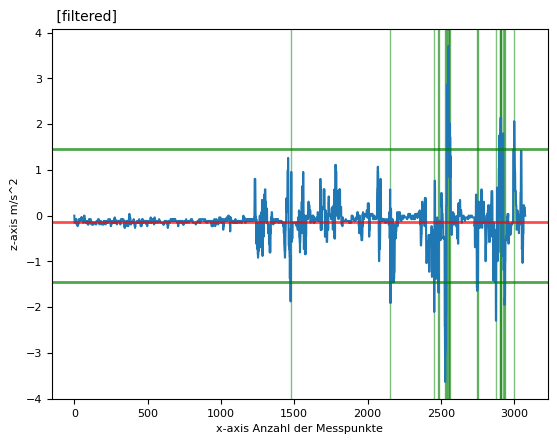

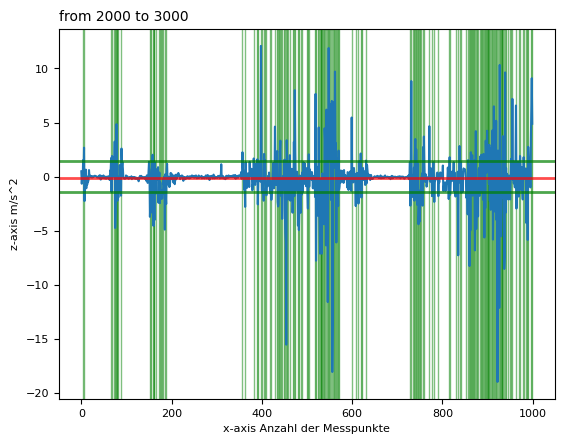

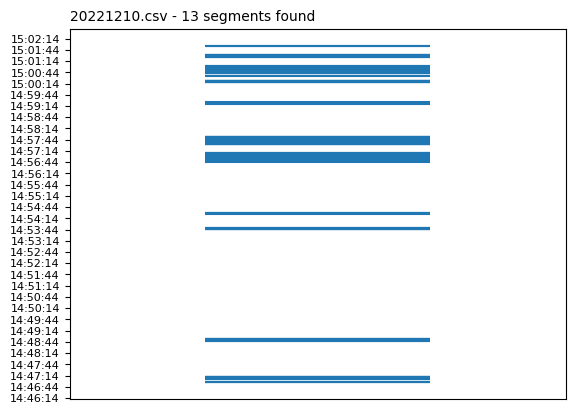

In [9]:
timestampslist = []
for value in eintraege:
    value = pd.to_datetime(value["timestamp"])
    timestampslist.append(value)

intervals = findIntervals(timestampslist)

# Create the segments. select the rows in the DataFrame where the timestamp 
# is greater than or equal to the start of the interval and less than or equal to the 
# end of the interval.
gnsssegments = []
for start, end in intervals:
    category = 0
    segment = gnssdata.loc[(gnssdata['timestamp'] >= start) & (gnssdata['timestamp'] <= end)]
    imu_segment = imu_data.loc[(imu_data['timestamp'] >= start) & (imu_data['timestamp'] <= end)]
    categories = list(map(int, list(set(imu_segment["category"]))))
    gnsssegments.append((segment, max(categories) if len(categories) else 0))

# for index, (element, category) in enumerate(gnsssegments):
#     if index > 0:
#         ids = uploadData(element, category)
#         print("segment uploaded to eddy server succesfully - upload qty={}".format(len(ids)))


plotRawAz(0, az.shape[0])
# plotRawAz(200, 500, "from 200 to 500", kernel_size=kernel_size)
# plotRawAz(2600, 2700, "from 2600 to 2700",kernel_size=kernel_size)
plotRawAz(2000, 3000,  "from 2000 to 3000",kernel_size=kernel_size)
plotIntervals(intervals=intervals, timestampslist=timestampslist)

In [78]:
# BT am 16.01.2023 ca 16:48 bis 1653 Uhr
# plotRawAz(37700, 44400, "from 37700 to 44400 - Berliner Tor M+P",kernel_size=kernel_size)

# plotRawAz(56750, 60000, "from 37700 to 44400 - Berliner Tor M+P",kernel_size=kernel_size)

# count = 0
# for index, element in enumerate(gnsssegments):
#     count = count + element.size

# print("segments found  {}".format(len(gnsssegments)))
# print("found lat longs {}".format(count))